# Vorhersage von Zeitreihen mit verschiedenen neuronalen Netzwerkarchitekturen

In diesem Notizbuch werden wir verschiedene Netzwerkarchitekturen verwenden, um die nächsten Schritte für eine Zeitreihe vorherzusagen. Wir vergleichen: 

* 1D kausale Faltungsnetzwerke 
* 1D kausale Faltungsnetzwerke mit Dilatationsrate
* RNNs  
* LSTMs

Wir prognostizieren eine Zeitreihe für längere Zeiträume als wir sie trainiert haben und vergleichen die Ergebnisse der verschiedenen Architekturen. Das Ziel ist es, die langfristigen Abhängigkeiten der Zeitreihe zu erfassen.

## Setup

### Einbinden von Paketen

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as keras

np.__version__, tf.__version__

('1.23.4', '2.11.0')

### Simulation von Daten

Wir erzeugen Trainingsdaten mit zwei verschiedenen Zeitskalen und ein wenig Rauschen. So entstehen **1000 Kurven**, die alle dem gleichen Muster folgen: eine sich _schnell ändernde Sinuswelle_, deren Amplitude von einer Sinuswelle mit niedrigerer Frequenz moduliert wird. Um die Sache etwas anspruchsvoller zu machen, fügen wir bei jedem Zeitschritt der Wellen etwas **Rauschen** hinzu. Alle 1000 Wellen haben das gleiche Muster, der _Startpunkt ist jedoch zufällig_ in der Zeit verschoben. Ein solches Beispiel ist im folgenden Diagramm dargestellt. Die ersten **128 Datenpunkte** werden als Eingabe für das Modell verwendet (als Linie dargestellt). Das Modell soll die folgenden **10 Datenpunkte** vorhersagen (als Punkte dargestellt). Beachten Sie, dass die zukünftigen Daten nicht einer glatten Kurve folgen, sondern aufgrund des in den Daten vorhandenen Zufallsrauschens zerklüftet sind.

/tmp/ipykernel_8686/3609720393.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')


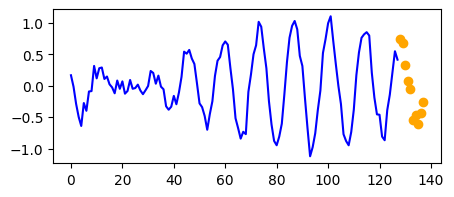

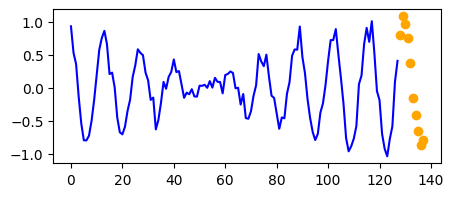

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [78]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D-Faltung ohne Dilatationsrate

### Netzwerk aufbauen
Hier definieren wir ein neuronales Netz mit 1D-Faltungen und "kausalem" Padding. 

Erstellen Sie ein erstes Modell unter Verwendung der kausalen Faltungen. Geben Sie die Sequenzlänge nicht an (batch_input_shape=(None, None, 1)), damit Sie später bei der Vorhersage eine andere Sequenzlänge verwenden können. Das Netzwerk sollte 4, 1-dimensionale Faltungsschichten haben, mit einer Kernelgröße von `ks=5` und 32 Features. Verwenden Sie dazu die Keras-Funktion `Convolution1D`. Das Netzwerk sollte am Ende 10 Werte ausgeben. Dies kann man mit folgender Funktion erreichen:

```{pyhon}
def slice(x, slice_length):
    return x[:,-slice_length:,:]
...
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Verwenden Sie die ersten 800 Sequenzen für das Training und die letzten 200 für die Validierung. Als Verlustfunktion verwenden wir den mittleren quadratischen Fehler (MSE). Sie sollten einen MSE von etwa 0,02 bis 0,03 erhalten.

In [79]:
from keras.models import Sequential
from keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN
from keras.optimizers import Adam

model_1 = Sequential()

# ks=5, 32 Features
model_1.add(Convolution1D(32, kernel_size=5, padding='causal', batch_input_shape=(None, None, 1)))
model_1.add(Convolution1D(32, kernel_size=5, padding='causal', batch_input_shape=(None, None, 1)))
model_1.add(Convolution1D(32, kernel_size=5, padding='causal', batch_input_shape=(None, None, 1)))
model_1.add(Convolution1D(32, kernel_size=5, padding='causal', batch_input_shape=(None, None, 1)))
model_1.add(Dense(1, activation='tanh')) # tanh, sonst MSE zu hoch

def slice(x, slice_length):
    return x[:,-slice_length:,:]

model_1.add(Lambda(slice, arguments={'slice_length': look_ahead}))

model_1.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))

model_1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, None, 32)          192       
                                                                 
 conv1d_45 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_46 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_47 (Conv1D)          (None, None, 32)          5152      
                                                                 
 dense_11 (Dense)            (None, None, 1)           33        
                                                                 
 lambda_11 (Lambda)          (None, None, 1)           0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-tra

In [80]:
model_1.fit(X[:800], Y[:800], validation_data=(X[800:], Y[800:]), batch_size=32, epochs=30)

Epoch 1/30
25/25 [==============================] - 0s 10ms/step - loss: 0.3190 - val_loss: 0.1070
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.0611 - val_loss: 0.0375
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.0396 - val_loss: 0.0368
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.0390 - val_loss: 0.0360
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0384 - val_loss: 0.0353
Epoch 6/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0379 - val_loss: 0.0347
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 0.0374 - val_loss: 0.0342
Epoch 8/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0368 - val_loss: 0.0336
Epoch 9/30
25/25 [==============================] - 0s 6ms/step - loss: 0.0362 - val_loss: 0.0329
Epoch 10/30
25/25 [==============================] - 0s 6ms/step - loss: 0.0355 - val_loss: 0.0324
Epoch 11/30
25/25 

### Wiederholte Vorhersagen machen

Da wir mit simulierten Daten arbeiten, können wir so viele neue Daten erzeugen, wie wir wollen. Wir können auch das Rauschen ausschalten und prüfen, wie gut das Modell das tatsächliche zugrunde liegende Muster in den Daten extrahieren kann.

In [81]:
x_test, y_test = gen_data(size=1, noise=0.0)
print(x_test.shape)
print(y_test.shape)
model_1.predict(x_test).reshape(-1) # Predicts 10 value

(1, 128, 1)
(1, 10, 1)
1/1 [==============================] - 0s 45ms/step


array([ 0.79807866,  0.75625324,  0.6018514 ,  0.27612567, -0.16084696,
       -0.4992581 , -0.6621006 , -0.69597495, -0.6226655 , -0.41268897],
      dtype=float32)

Schreibe eine Funktion, die 10 Werte aus einer Startsequenz der Größe 128 vorhersagt. Addiere dann diese vorhergesagten Werte zu der Ausgangssequenz und verwende diese Sequenz der Länge 138 als neue Ausgangssequenz. Wiederholen Sie diesen Vorgang 12 Mal. Du solltest eine Vorhersage für 120 Zeitpunkte in der Zukunft erhalten.

In [82]:
x_test, y_test = gen_data(size=1, noise=0.0)

def predict(sequence):
    pred = model_1.predict(sequence)
    new_sequence = np.append(sequence, pred)
    new_sequence = new_sequence.reshape((1, len(new_sequence), 1))
    return new_sequence

y_pred = predict(x_test)
for x in range(11):
    y_pred = predict(y_pred)

# Remove data which is already in x_test
y_pred = y_pred[:, 128:]

print(x_test.shape)
print(y_pred.shape)

1/1 [==============================] - 0s 10ms/step
(1, 128, 1)
(1, 120, 1)


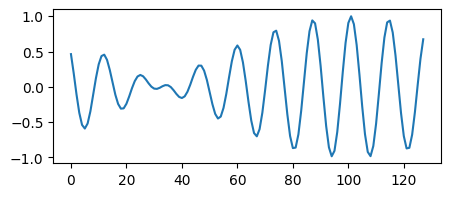

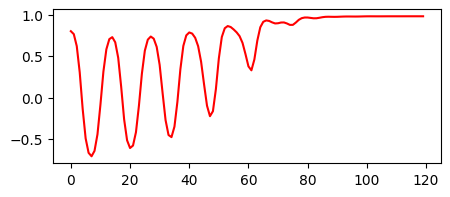

In [83]:
# Test
plt.figure(figsize=(5, 2))  
plt.plot(x_test[0,:,0])
plt.show()

# Prediction
plt.figure(figsize=(5, 2))  
plt.plot(y_pred[0,:,0], color='red')
plt.show()

## B) 1D-Faltung mit Dilatationsrate

Hier definieren wir ein neuronales Netz mit 1D-Faltung und "kausalem" Padding, diesmal mit Dilatationsrate, so dass wir in der Lage sind, länger in der Zeit zurückzublicken (siehe Abbildung).

![](https://i.stack.imgur.com/20xRe.png)

Bauen Sie dasselbe Netz wie in A) auf, aber diesmal mit den Dilatationsraten 1, 2, 4, 8:

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN
from keras.optimizers import Adam

model_2 = Sequential()

# ks=5, 32 Features
model_2.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=1, batch_input_shape=(None, None, 1)))
model_2.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=2, batch_input_shape=(None, None, 1)))
model_2.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=4, batch_input_shape=(None, None, 1)))
model_2.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=8, batch_input_shape=(None, None, 1)))
model_2.add(Dense(1, activation='tanh')) # tanh, sonst MSE zu hoch

def slice(x, slice_length):
    return x[:,-slice_length:,:]

model_2.add(Lambda(slice, arguments={'slice_length': look_ahead}))

model_2.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))

model_2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, None, 32)          192       
                                                                 
 conv1d_49 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_50 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_51 (Conv1D)          (None, None, 32)          5152      
                                                                 
 dense_12 (Dense)            (None, None, 1)           33        
                                                                 
 lambda_12 (Lambda)          (None, None, 1)           0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-tra

In [85]:
model_2.fit(X[:800], Y[:800], validation_data=(X[800:], Y[800:]), batch_size=32, epochs=30)

Epoch 1/30
25/25 [==============================] - 0s 10ms/step - loss: 0.1727 - val_loss: 0.0871
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0685 - val_loss: 0.0425
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0361 - val_loss: 0.0250
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.0183
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0181 - val_loss: 0.0157
Epoch 6/30
25/25 [==============================] - 0s 9ms/step - loss: 0.0163 - val_loss: 0.0147
Epoch 7/30
25/25 [==============================] - 0s 8ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 8/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 9/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 10/30
25/25 [==============================] - 0s 7ms/step - loss: 0.0153 - val_loss: 0.0142
Epoch 11/30
25/25 

### Wiederholte Vorhersagen machen

Wie in A) wiederholte Vorhersagen auf Basis von Daten ohne Rauschen.

In [86]:
x_test, y_test = gen_data(size=1, noise=0.0)

def predict(sequence):
    pred = model_2.predict(sequence)
    new_sequence = np.append(sequence, pred)
    new_sequence = new_sequence.reshape((1, len(new_sequence), 1))
    return new_sequence

y_pred = predict(x_test)
for x in range(11):
    y_pred = predict(y_pred)

# Remove data which is already in x_test
y_pred = y_pred[:, 128:]

print(x_test.shape)
print(y_pred.shape)

1/1 [==============================] - 0s 10ms/step
(1, 128, 1)
(1, 120, 1)


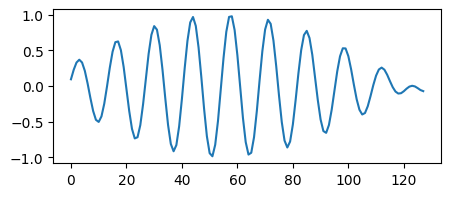

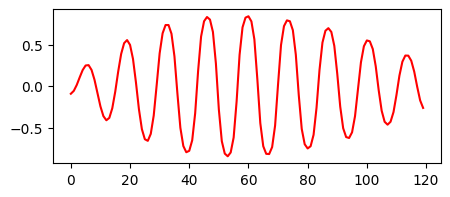

In [87]:
# Test
plt.figure(figsize=(5, 2))  
plt.plot(x_test[0,:,0])
plt.show()

# Prediction
plt.figure(figsize=(5, 2))  
plt.plot(y_pred[0,:,0], color='red')
plt.show()

## C) Einfaches RNN

Verwenden Sie nun eine RNN-Zelle `SimpleRNN` (Keras), um zu sehen, ob wir in der Lage sind, den Datenerzeugungsprozess zu lernen. Beginnen Sie mit einer versteckten Zustandsgröße von 12. Wiederholen Sie die Aufgabe aus A) und B). Erwägen Sie, mehrere Schichten von Zellen hinzuzufügen und mit der Zustandsgröße zu spielen.

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN
from keras.optimizers import Adam

model_3 = Sequential()

# ks=5, 32 Features
model_3.add(SimpleRNN(units=30, input_shape=(None, 1), return_sequences=True, name='RNN'))
model_3.add(SimpleRNN(units=30, input_shape=(None, 1), return_sequences=True, name='RNN2'))
model_3.add(Convolution1D(32, kernel_size=5, padding='causal',dilation_rate=1, batch_input_shape=(None, None, 1)))
model_3.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=2, batch_input_shape=(None, None, 1)))
model_3.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=4, batch_input_shape=(None, None, 1)))
model_3.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=8, batch_input_shape=(None, None, 1)))
model_3.add(Dense(1, activation='tanh')) 

def slice(x, slice_length):
    return x[:,-slice_length:,:]

model_3.add(Lambda(slice, arguments={'slice_length': look_ahead}))

model_3.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RNN (SimpleRNN)             (None, None, 30)          960       
                                                                 
 RNN2 (SimpleRNN)            (None, None, 30)          1830      
                                                                 
 conv1d_52 (Conv1D)          (None, None, 32)          4832      
                                                                 
 conv1d_53 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_54 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_55 (Conv1D)          (None, None, 32)          5152      
                                                                 
 dense_13 (Dense)            (None, None, 1)         

In [89]:
model_3.fit(X[:800], Y[:800], validation_data=(X[800:], Y[800:]), batch_size=32, epochs=30)

Epoch 1/30
25/25 [==============================] - 1s 26ms/step - loss: 0.1119 - val_loss: 0.0454
Epoch 2/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0376 - val_loss: 0.0300
Epoch 3/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0277 - val_loss: 0.0248
Epoch 4/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0232 - val_loss: 0.0213
Epoch 5/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0203 - val_loss: 0.0187
Epoch 6/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0183 - val_loss: 0.0167
Epoch 7/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0167 - val_loss: 0.0155
Epoch 8/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 9/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 10/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0145 - val_loss: 0.0137
Epoch 11/

### Wiederholte Vorhersagen machen

Wie in A) wiederholte Vorhersagen auf Basis von Daten ohne Rauschen.

In [90]:
x_test, y_test = gen_data(size=1, noise=0.0)

def predict(sequence):
    pred = model_3.predict(sequence)
    new_sequence = np.append(sequence, pred)
    new_sequence = new_sequence.reshape((1, len(new_sequence), 1))
    return new_sequence

y_pred = predict(x_test)
for x in range(11):
    y_pred = predict(y_pred)

# Remove data which is already in x_test
y_pred = y_pred[:, 128:]

print(x_test.shape)
print(y_pred.shape)

1/1 [==============================] - 0s 18ms/step
(1, 128, 1)
(1, 120, 1)


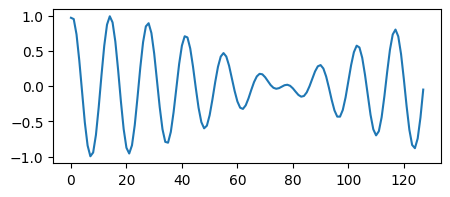

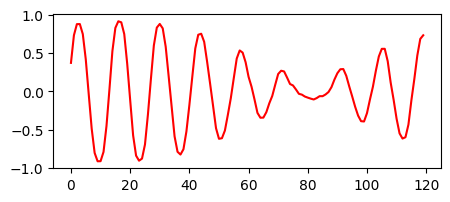

In [91]:
# Test
plt.figure(figsize=(5, 2))  
plt.plot(x_test[0,:,0])
plt.show()

# Prediction
plt.figure(figsize=(5, 2))  
plt.plot(y_pred[0,:,0], color='red')
plt.show()

## D) LSTM-Zelle

Wiederholen Sie C), aber jetzt mit einer LSTM-Zelle.

In [92]:
from keras.models import Sequential
from keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN
from keras.optimizers import Adam

model_4 = Sequential()

# ks=5, 32 Features
model_4.add(LSTM(units=10, input_shape=(None, 1), return_sequences=True, name='LSTM'))
model_4.add(LSTM(units=10, input_shape=(None, 1), return_sequences=True, name='LSTM2'))
model_4.add(Convolution1D(32, kernel_size=5, padding='causal',dilation_rate=1, batch_input_shape=(None, None, 1)))
model_4.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=2, batch_input_shape=(None, None, 1)))
model_4.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=4, batch_input_shape=(None, None, 1)))
model_4.add(Convolution1D(32, kernel_size=5, padding='causal', dilation_rate=8, batch_input_shape=(None, None, 1)))
model_4.add(Dense(1, activation='tanh')) 

def slice(x, slice_length):
    return x[:,-slice_length:,:]

model_4.add(Lambda(slice, arguments={'slice_length': look_ahead}))

model_4.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))

model_4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, None, 10)          480       
                                                                 
 LSTM2 (LSTM)                (None, None, 10)          840       
                                                                 
 conv1d_56 (Conv1D)          (None, None, 32)          1632      
                                                                 
 conv1d_57 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_58 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_59 (Conv1D)          (None, None, 32)          5152      
                                                                 
 dense_14 (Dense)            (None, None, 1)         

In [93]:
model_4.fit(X[:800], Y[:800], validation_data=(X[800:], Y[800:]), batch_size=32, epochs=30)

Epoch 1/30
25/25 [==============================] - 2s 37ms/step - loss: 0.2462 - val_loss: 0.2126
Epoch 2/30
25/25 [==============================] - 1s 25ms/step - loss: 0.1891 - val_loss: 0.1465
Epoch 3/30
25/25 [==============================] - 1s 35ms/step - loss: 0.1274 - val_loss: 0.0930
Epoch 4/30
25/25 [==============================] - 1s 25ms/step - loss: 0.0872 - val_loss: 0.0681
Epoch 5/30
25/25 [==============================] - 1s 26ms/step - loss: 0.0632 - val_loss: 0.0477
Epoch 6/30
25/25 [==============================] - 1s 26ms/step - loss: 0.0420 - val_loss: 0.0295
Epoch 7/30
25/25 [==============================] - 1s 26ms/step - loss: 0.0254 - val_loss: 0.0183
Epoch 8/30
25/25 [==============================] - 1s 26ms/step - loss: 0.0176 - val_loss: 0.0151
Epoch 9/30
25/25 [==============================] - 1s 30ms/step - loss: 0.0160 - val_loss: 0.0149
Epoch 10/30
25/25 [==============================] - 1s 27ms/step - loss: 0.0158 - val_loss: 0.0148
Epoch 11/

In [94]:
x_test, y_test = gen_data(size=1, noise=0.0)

def predict(sequence):
    pred = model_4.predict(sequence)
    new_sequence = np.append(sequence, pred)
    new_sequence = new_sequence.reshape((1, len(new_sequence), 1))
    return new_sequence

y_pred = predict(x_test)
for x in range(11):
    y_pred = predict(y_pred)

# Remove data which is already in x_test
y_pred = y_pred[:, 128:]

print(x_test.shape)
print(y_pred.shape)

1/1 [==============================] - 0s 16ms/step
(1, 128, 1)
(1, 120, 1)


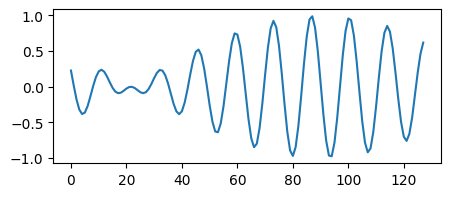

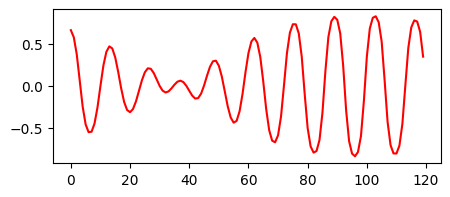

In [95]:
# Test
plt.figure(figsize=(5, 2))  
plt.plot(x_test[0,:,0])
plt.show()

# Prediction
plt.figure(figsize=(5, 2))  
plt.plot(y_pred[0,:,0], color='red')
plt.show()